## **DOMAIN**: **Botanical research**

## PROJECT OBJECTIVE: University’s management require an automation which can create a classifier capable of determining a plant's species from a photo

### 1. Import the data. Analyse the dimensions of the data. Visualise the data.

In [63]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [64]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [65]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [68]:
project_path = "/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/"

In [69]:
!ls

drive  sample_data


In [70]:
import os
for dirname, _,filenames in os.walk('/content/drive/My Drive/AIML'):
  for filename in filenames:
    print(os.path.join(dirname,filename))

/content/drive/My Drive/AIML/CV_Project2/Part 1- Train data - images.npy
/content/drive/My Drive/AIML/CV_Project2/fdata.csv
/content/drive/My Drive/AIML/CV_Project2/finaldata.csv
/content/drive/My Drive/AIML/CV_Project2/fdata.gsheet
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/Small-flowered Cranesbill/e19c8b666.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/Small-flowered Cranesbill/e29577320.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/Small-flowered Cranesbill/efbf3750d.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/Small-flowered Cranesbill/ec87dcbbf.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/Small-flowered Cranesbill/db360e6d2.png
/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classificati

In [71]:
import os
seed_type=os.listdir('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train')

In [72]:
seed_type

['Small-flowered Cranesbill',
 'Common wheat',
 'Cleavers',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Fat Hen',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Maize',
 'Charlock',
 'Black-grass']

In [154]:
train_dir='/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train'
SPECIES=['Small-flowered Cranesbill','Common wheat','Cleavers','Shepherds Purse','Loose Silky-bent',
 'Fat Hen',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Maize',
 'Charlock',
 'Black-grass']

for species in SPECIES:
     print('{} {} images'.format(species,len(os.listdir(os.path.join(train_dir,species)))))

Small-flowered Cranesbill 496 images
Common wheat 221 images
Cleavers 287 images
Shepherds Purse 231 images
Loose Silky-bent 671 images
Fat Hen 475 images
Scentless Mayweed 516 images
Common Chickweed 611 images
Sugar beet 385 images
Maize 221 images
Charlock 390 images
Black-grass 263 images


In [155]:
import pathlib
from glob import glob

image_path='/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train'
image_path=pathlib.Path(image_path)
image_count=len(list(image_path.glob('*/*.png')))
print("Total number of images",image_count)


Total number of images 4767


Total number of image of sugar beet plant 385


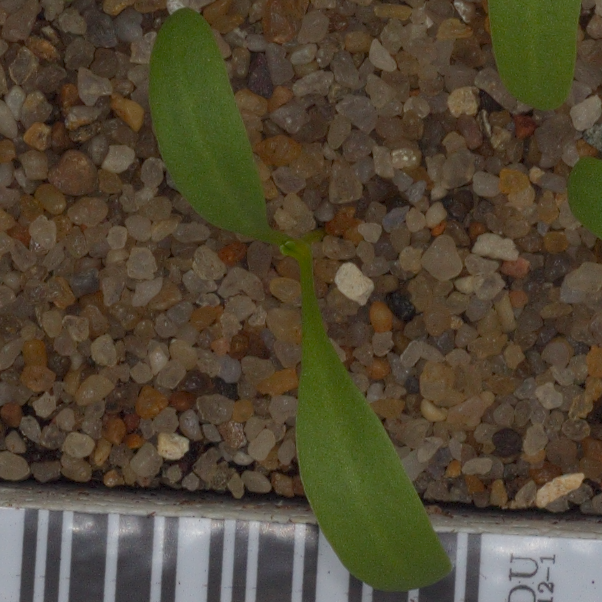

In [156]:
import numpy as np
import pandas as pd

import PIL
import PIL.Image
plant=list(image_path.glob('Sugar beet/*'))
print("Total number of image of sugar beet plant",len(plant))
PIL.Image.open(str(plant[1]))


Organising training files into DataFrame

In [157]:
import cv2
image_path='/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train/*/*.png'

scale=70

images=glob(image_path)
TrainSet_X=[]
TrainLabel_y=[]
num_images=len(images)

#Reading and Resizing
print("Reading Data")
for i in images:
  TrainSet_X.append(cv2.resize(cv2.imread(i),(scale,scale)))
  TrainLabel_y.append(i.split('/')[-2])

print("Data Read Complete")
TrainSet_X=np.asarray(TrainSet_X)
TrainLabel_y=pd.DataFrame(TrainLabel_y)

Reading Data
Data Read Complete


In [158]:
print(TrainSet_X.shape)
print(TrainLabel_y.shape)

(4767, 70, 70, 3)
(4767, 1)


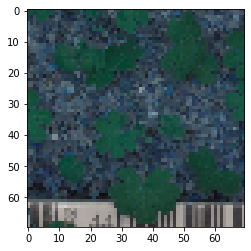

In [159]:
import matplotlib.pyplot as plt

plt.imshow(TrainSet_X[0])

Cleaning the images and removing the background. 
1.Convert the RGB images into HSV
2.In order to remove the noise, we will have to blur the images
3.In order to remove the background, we will have to create a mask.

In [285]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.models import Sequential,Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense,Activation
from keras.layers import Dropout
from keras.layers import Flatten
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix

#surpress display of warning
import warnings
warnings.filterwarnings('ignore')

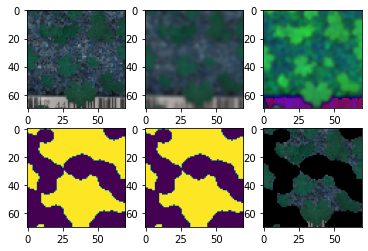

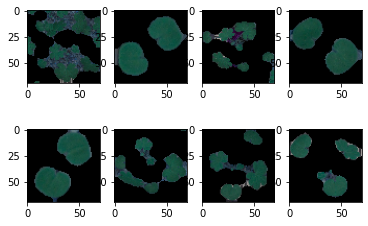

In [286]:
new_train=[]
sets=[]
getEx=True
for i in TrainSet_X:
  blurr=cv2.GaussianBlur(i,(5,5),0)
  hsv=cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)

  #Green Parameters
  lower=(25,40,50)
  upper=(75,255,255)
  mask=cv2.inRange(hsv,lower,upper)

  struc=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)

  boolean=mask>0
  new=np.zeros_like(i,np.uint8)
  new[boolean]=i[boolean]

  new_train.append(new)

  if getEx:
    plt.subplot(2,3,1) #Original Image
    plt.imshow(i)

    plt.subplot(2,3,2) #Blurred Image
    plt.imshow(blurr)

    plt.subplot(2,3,3) #HSV Converted Image
    plt.imshow(hsv)

    plt.subplot(2,3,4) #Masked Image
    plt.imshow(mask)

    plt.subplot(2,3,5) #Boolean Masked Image
    plt.imshow(boolean)

    plt.subplot(2,3,6) #New Processed Image
    plt.imshow(new)

    plt.show()

    getEx=False

new_train=np.asarray(new_train)

#Cleaned Images
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])


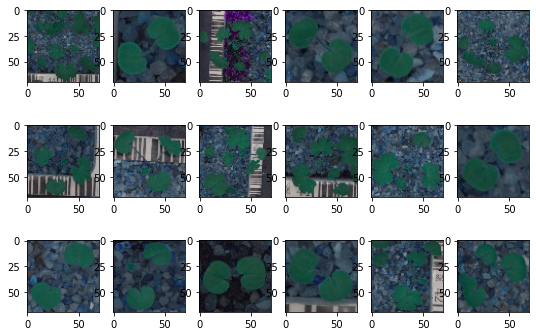

In [287]:
num=18
num_row=3
num_col=6

fig,axes=plt.subplots(num_row,num_col,figsize=(1.5*num_col,2*num_row))

for i in range(num):
  ax=axes[i//num_col,i%num_col]
  ax.imshow(TrainSet_X[i],cmap='gray')

plt.show()

Converting the labels into numbers.
Labels are hard to process So, we will convert these labels into binary classification.
0 if the species is not detected
1 if the species is detected

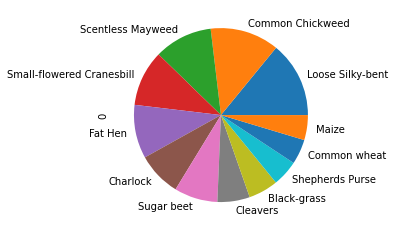

In [288]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

def convert_images(x):
  X=np.array(TrainSet_X)
  return X

def convert_labels(TrainLabel_y):
  enc=LabelEncoder()
  P=enc.fit_transform(TrainLabel_y)

  y=to_categorical(P)
  return y

TrainLabel_y[0].value_counts().plot(kind='pie')

Splitting the Dataset

In [289]:
from sklearn.model_selection import train_test_split
#Normalization
X=np.array(TrainSet_X)/255.0
y=convert_labels(TrainLabel_y)

#Splitting
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=2)

X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train/=255
X_test/=255

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)

print("Shape of validating data:")
print(X_val.shape)
print(y_val.shape)

print("Shape of testing data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(3813, 70, 70, 3)
(3813, 12)
Shape of validating data:
(477, 70, 70, 3)
(477, 12)
Shape of testing data:
(477, 70, 70, 3)
(477, 12)


In [290]:
image_shape=X_train[1].shape
print("Input Image Shape is :",image_shape)

Input Image Shape is : (70, 70, 3)


In [291]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator for training data with data augmentation and normalizing all
# values by 255
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

# Setting training data generator's source directory
# Setting the target size to resize all the images to (64,64) as the model input layer expects 64X64 images
training_set=train_datagen.flow_from_directory('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/train',target_size=(64,64),batch_size=32,class_mode='categorical')

# Setting testing data generator's source directory
test_set=test_datagen.flow_from_directory('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/',target_size=(64,64),batch_size=32,class_mode='categorical')


Found 4767 images belonging to 12 classes.
Found 4768 images belonging to 2 classes.


#**Build CNN Model**

In [292]:
def construct_model():

  model1=Sequential()

  model1.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2,2)))
  model1.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2,2)))
  model1.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=image_shape,activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2,2)))
  model1.add(Flatten())
  model1.add(Dense(128,activation='relu'))
  model1.add(Dropout(0.5))

  model1.add(Dense(12,activation='softmax'))

  model1.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

  return model1

## Summary of Model

In [293]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)        

###Preventing Overfitting and Data Augmentation

In [294]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
def train_model():
    model1=construct_model()
    annealer=ReduceLROnPlateau(monitor='val_acc',factor=0.5,patience=5,verbose=1,min_lr=1e-5)

    datagen=ImageDataGenerator(rotation_range=360,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
    datagen.fit

    hist=model1.fit_generator(datagen.flow(X_train,y_train,batch_size=16),steps_per_epoch=X_train.shape[0],epochs=10,verbose=2,callbacks=[annealer],validation_data=(X_val,y_val))

###Accuracy

In [295]:
cnn_train_score=model1.evaluate(X_train,y_train)
print(cnn_train_score)
print('Train accuracy: ', cnn_train_score[1])

120/120 [==============================] - 8s 65ms/step - loss: 2.4189 - accuracy: 0.1437
[2.418896436691284, 0.14371885359287262]
Train accuracy:  0.14371885359287262


In [296]:
cnn_test_score=model1.evaluate(X_test,y_test)
print(cnn_test_score)
print('Train accuracy: ', cnn_test_score[1])

15/15 [==============================] - 1s 68ms/step - loss: 2.4323 - accuracy: 0.1153
[2.4322903156280518, 0.11530398577451706]
Train accuracy:  0.11530398577451706


###Prediction

In [297]:
print("CNN Merics")

cnn_y_pred=model1.predict(X_test)
print(cnn_y_pred.shape)

y_pred_class=np.argmax(cnn_y_pred,axis=1)
#print(cnn_pred)
y_check=np.argmax(y_test,axis=1)

#print("Classification Report\n",classification_report(y_check,y_pred_class))

val_score1=accuracy_score(y_check,y_pred_class)
print(val_score1)

CNN Merics
(477, 12)
0.11530398322851153


# **Build NN Model**

### Extracting Features from last layer

In [298]:
model_feat=Model(inputs=model1.input,outputs=model1.get_layer('dense_1').output)

feat_train=model_feat.predict(X_train)
print(feat_train.shape)

feat_val=model_feat.predict(X_val)
print(feat_val.shape)

feat_test=model_feat.predict(X_test)
print(feat_test.shape)

(3813, 12)
(477, 12)
(477, 12)


In [299]:
#fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [300]:
def adam2_with_batchDropout_model():

  model = tf.keras.models.Sequential()

  model.add(Dense(50, input_shape = (12, )))
  model.add(Activation('sigmoid'))
  model.add(Dense(50))
  model.add(Activation('sigmoid'))
  model.add(Dense(50))
  model.add(Activation('sigmoid'))
  model.add(Dense(50))
  model.add(Activation('sigmoid'))
  model.add(Dense(12))
  model.add(Activation('softmax'))

  sgd = optimizers.SGD(lr = 0.01)
  model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [301]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 50)                650       
                                                                 
 activation_35 (Activation)  (None, 50)                0         
                                                                 
 dense_148 (Dense)           (None, 50)                2550      
                                                                 
 activation_36 (Activation)  (None, 50)                0         
                                                                 
 dense_149 (Dense)           (None, 50)                2550      
                                                                 
 activation_37 (Activation)  (None, 50)                0         
                                                                 
 dense_150 (Dense)           (None, 50)              

In [302]:
model=adam2_with_batchDropout_model()
history_model_2=model.fit(x=feat_train, y=y_train, batch_size=32, epochs=10, validation_split = 0.3)

Epoch 1/10
84/84 [==============================] - 1s 5ms/step - loss: 2.5526 - accuracy: 0.1184 - val_loss: 2.4417 - val_accuracy: 0.1512
Epoch 2/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4285 - accuracy: 0.1349 - val_loss: 2.4163 - val_accuracy: 0.1337
Epoch 3/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4180 - accuracy: 0.1480 - val_loss: 2.4110 - val_accuracy: 0.1337
Epoch 4/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4163 - accuracy: 0.1480 - val_loss: 2.4091 - val_accuracy: 0.1337
Epoch 5/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4162 - accuracy: 0.1480 - val_loss: 2.4097 - val_accuracy: 0.1337
Epoch 6/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4162 - accuracy: 0.1480 - val_loss: 2.4084 - val_accuracy: 0.1337
Epoch 7/10
84/84 [==============================] - 0s 3ms/step - loss: 2.4161 - accuracy: 0.1480 - val_loss: 2.4099 - val_accuracy: 0.1337
Epoch 8/10
84/84 [==

Accuracy

In [303]:
NNscore_train=model.evaluate(feat_train,y_train)
print(NNscore_train)
print('Train accuracy: ', NNscore_train[1])

120/120 [==============================] - 0s 2ms/step - loss: 2.4135 - accuracy: 0.1437
[2.413492441177368, 0.14371885359287262]
Train accuracy:  0.14371885359287262


In [304]:
NNscore_test=model.evaluate(feat_test, y_test)
print(NNscore_test)
print('Test accuracy: ', NNscore_test[1])

15/15 [==============================] - 0s 2ms/step - loss: 2.4343 - accuracy: 0.1153
[2.434274435043335, 0.11530398577451706]
Test accuracy:  0.11530398577451706


Prediction

In [305]:
print("NN Merics")

y_pred2=model.predict(feat_test)
print(y_pred2.shape)

y_class2=np.argmax(y_pred2,axis=1)
#print(cnn_pred)
y_check2=np.argmax(y_test,axis=1)

val_score2=accuracy_score(y_check2,y_class2)
print("Prediction Score",val_score2)

NN Merics
(477, 12)
Prediction Score 0.11530398322851153


## **Build Supervised Learning Algorithm(SVC)**

### Extracting Features from last layer

In [306]:
model_feat_two=Model(inputs=model1.input,outputs=model1.get_layer('dense_1').output)

feat_train2=model_feat_two.predict(X_train)
print(feat_train2.shape)

feat_val2=model_feat_two.predict(X_val)
print(feat_val2.shape)

feat_test2=model_feat_two.predict(X_test)
print(feat_test2.shape)

(3813, 12)
(477, 12)
(477, 12)


Building SVM model

In [307]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid=[{'C':[1,10,100,1000],'kernel':['linear']},{'C':[1,10,100,1000],'gamma':[0.001,0.0001],'kernel':['rbf']},]
svc=SVC()
svc_model=GridSearchCV(svc,param_grid)
svc_model.fit(feat_train2,np.argmax(y_train,axis=1))

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

### Accuracy

In [308]:
svc_train_score=svc_model.score(feat_train2,np.argmax(y_train,axis=1))
print(svc_train_score)

0.14371885654340413


In [309]:
svc_test_score=svc_model.score(feat_test2,np.argmax(y_test,axis=1))
print(svc_test_score)

0.11530398322851153


In [310]:
print("SVC Merics")

svc_y_pred=svc_model.predict(feat_test2)
print(svc_y_pred.shape)

SVC Merics
(477,)


### 3. Compare the results from the above step along with your detailed observations on the best performing algorithm and why/how it outperforms other algorithms in this case.

In [311]:
models=pd.DataFrame({'Model':['CNN','NN','SVM'],
                     'Training Accuracy':[cnn_train_score[1],NNscore_train[1],svc_train_score],
                    'Testing Accuracy':[cnn_test_score[1],NNscore_test[1],svc_test_score]})
            
models.sort_index()

,Model,Training Accuracy,Testing Accuracy
0,CNN,0.143719,0.115304
1,NN,0.143719,0.115304
2,SVM,0.143719,0.115304


### 4. Pickle the best performing model.

In [312]:
training_set.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [313]:
class_labels=list(training_set.class_indices)
class_labels

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [316]:
#Set the path where you want to store the model and weights 
model1.save('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/cnn_svhn.h5')
model1.save_weights('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/cnn_svhn_weights.h5')

### 5. Import the the test image [ from the “ Prediction” folder ] to predict the class. Display the image. Use the best trained image classifier model to predict the class.

In [315]:
#test the model on one single image from the test folder

import cv2
test_image=cv2.imread('/content/drive/My Drive/AIML/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png')


# Check if the size of the Image array is compatible with Keras model
print(test_image.shape)

# Reshape the image to 64x64x3
test_image=cv2.resize(test_image,(70,70))
print(test_image.shape)

# If not compatible expand the dimensions to match with the Keras Input
test_image=np.expand_dims(test_image,axis=0)
test_image=test_image*1/255.0

#Check the size of the Image array again
print('After expand dims:'+str(test_image.shape))

#Predict the result of the test image
result=model1.predict(test_image)

# Check the indices Image Data Generator has allotted to each folder
classes_dict=training_set.class_indices
print(classes_dict)

# Creating a list of classes in test set for showing the result as the folder name
prediction_class=[]
for class_name,index in classes_dict.items():
  prediction_class.append(class_name)
  
print(result[0])

# Index of the class with maximum probability
predicted_index=np.argmax(result[0])

# Print the name of the class
print(prediction_class[predicted_index])

(578, 578, 3)
(70, 70, 3)
After expand dims:(1, 70, 70, 3)
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
[0.00854629 0.02173891 0.01242206 0.19363302 0.00487837 0.0656529
 0.38167506 0.00824799 0.15081078 0.00749965 0.11222252 0.03267244]
Loose Silky-bent
